# Preamble

In [1]:
from sympy import init_session
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_styles import analytic
import numpy as npy
import scipy as sp
%matplotlib widget
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle
from sympy.utilities.lambdify import lambdastr
init_session()

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [2]:
# Positive constant
M, G, q, mu1, mu2, m1, m2, b1, b2, j, b1_3_2, b2_3_2 = symbols(
    r"M G q mu_1 mu_2 m_1, m_2, beta_1 beta_2 j b_{3/2}^{(1)}(\alpha_0) b_{3/2}^{(2)}(\alpha_0)",
    positive=True,
)
# Positive timescales
Tm1, Tm2, Te1, Te2 = symbols(
    r"T_{m\,1} T_{m\,2} T_{e\,1} T_{e\,2}",
    positive=True,
)
# Precession frequencies
om1, om2 = symbols("omega_1 omega_2")
# Angles of time
l1, l2, pom1, pom2, th1, th2, th0 = symbols("l_1 l_2 varpi_1 varpi_2 theta_1 theta_2 theta_0")
# Positive functions of time
e1, e2, a1, a2, n1, n2, alpha = symbols("e_1 e_2 a_1 a_2 n_1 n_2 alpha", positive=True)
# Actions
Gam1, Gam2, Lam1, Lam2 = symbols("Gamma_1 Gamma_2 Lambda_1 Lambda_2", positive=True)
# Derivatives
dth1, dth2 = symbols(r"\dot\theta_1 \dot\theta_2")

In [3]:
EXPRS = {}
EXPRS[th1] = (j + 1) * l2 - j * l1 - pom1
EXPRS[th2] = (j + 1) * l2 - j * l1 - pom2
EXPRS[Lam1] = q*sqrt(a1)
EXPRS[Lam2] = sqrt(a2)
EXPRS[Gam1] = Rational(1,2)*q*sqrt(a1)*e1**2
EXPRS[Gam2] = Rational(1,2)*sqrt(a2)*e2**2

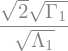

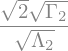

In [4]:
CANON = {}
CANON[a1] = solve(EXPRS[Lam1]-Lam1,a1)[0]
CANON[e1] = solve(EXPRS[Gam1]-Gam1,e1)[0].subs(a1,CANON[a1])
CANON[a2] = solve(EXPRS[Lam2]-Lam2,a2)[0]
CANON[e2] = solve(EXPRS[Gam2]-Gam2,e2)[0].subs(a2,CANON[a2])
display(CANON[a1])
display(CANON[e1])
display(CANON[a2])
display(CANON[e2])

In [5]:
def term_simplify(expr):
    run = 0
    for arg in expr.args:
        run += arg.simplify()
    return(run)

def term_multiply(expr, mult):
    run = 0
    for term in expr.args:
        run += term*mult
    term_simplify(run)
    return(run)

def chain_rule(expr, var):
    run = expr.diff(var)
    for key in EXPRS.keys():
        run += expr.diff(key)*EXPRS[key].diff(var)
    for key in CANON.keys():
        run += expr.diff(key)*CANON[key].diff(var)
    return(run)

def to_orbelts(expr):
    for var in [Lam1, Lam2, Gam1, Gam2]:
        expr = expr.subs(var,EXPRS[var])
    return(expr)

- Assume $a_2\approx a_{2,0}[=1]$ in denominator of perturbation term.
- $\beta_1=-f_{27}(\alpha_0)$ and $\beta_2=f_{31}(\alpha_0)$ 

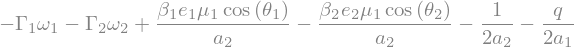

In [6]:
H_expr = -Rational(1,2)*q/a1 - Rational(1,2)*1/a2 + mu1*b1*e1*cos(th1)/a2 - mu1*b2*e2*cos(th2)/a2 - Gam1*om1 - Gam2*om2 
H_expr

Doing 2 different R_i for each planet to reduce typos over from Murray & Dermott.

Units are in $[n_{2,0}]$, $[a_{2,0}]$, and $[M]$

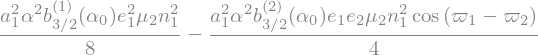

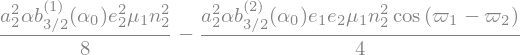

In [7]:
#A11 = Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b1_3_2
#A12 = -Rational(1,4)*n1*m2/(M+m1)*alpha*alpha*b2_3_2
#A21 = -Rational(1,4)*n2*m1/(M+m2)*alpha*b2_3_2
#A22 = Rational(1,4)*n2*m1/(M+m2)*alpha*b1_3_2
A11 = Rational(1,4)*n1*mu2*alpha*alpha*b1_3_2
A12 = -Rational(1,4)*n1*mu2*alpha*alpha*b2_3_2
A21 = -Rational(1,4)*n2*mu1*alpha*b2_3_2
A22 = Rational(1,4)*n2*mu1*alpha*b1_3_2

R1 = (n1*a1**2*(Rational(1,2)*A11*e1**2 + A12*e1*e2*cos(pom1-pom2))).expand()
R2 = (n2*a2**2*(Rational(1,2)*A22*e2**2 + A21*e1*e2*cos(pom1-pom2))).expand()
#term_multiply(R1.expand().subs(n1**2,G*M*m1/a1**3),1/(G*M*m2)).subs({m1:mu1*M,m2:mu2*M}).cancel()
display(R1)
display(R2)

# Equations of motion

## Resonant

### $\dot\Lambda_1$, $\dot\Lambda_2$

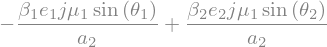

In [8]:
Lam1_dot_res = -chain_rule(H_expr,l1)
Lam1_dot_res

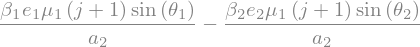

In [9]:
Lam2_dot_res = -chain_rule(H_expr,l2)
Lam2_dot_res

### $\dot n_1$, $\dot n_2$

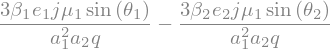

In [ ]:
n1_dot_res = term_multiply(Lam1_dot_res, -3*q**3 / Lam1**4).subs(Lam1,EXPRS[Lam1])
n1_dot_res

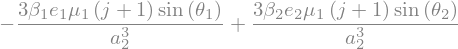

In [35]:
n2_dot_res = term_multiply(Lam2_dot_res, -3 / Lam2**4).subs(Lam2,EXPRS[Lam2])
n2_dot_res

### $\dot\Gamma_1$, $\dot\Gamma_2$

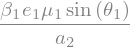

In [12]:
Gam1_dot_res = chain_rule(H_expr,pom1)
Gam1_dot_res

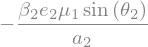

In [13]:
Gam2_dot_res = chain_rule(H_expr,pom2)
Gam2_dot_res

### $\dot\varpi_1$, $\dot\varpi_2$

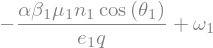

In [14]:
pom1_dot_res = to_orbelts(-chain_rule(H_expr,Gam1)).subs(a2, a1/alpha).subs(a1,n1**Rational(-2,3))
pom1_dot_res

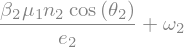

In [15]:
pom2_dot_res = to_orbelts(-chain_rule(H_expr,Gam2)).subs(a2,n2**Rational(-2,3))
pom2_dot_res

### $\dot\lambda_1$, $\dot\lambda_2$

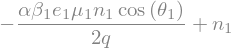

In [16]:
l1_dot_res = to_orbelts(chain_rule(H_expr,Lam1)).subs(a2, a1/alpha).subs(a1,n1**Rational(-2,3))
l1_dot_res

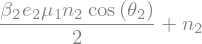

In [17]:
l2_dot_res = to_orbelts(chain_rule(H_expr.subs(b2/a2,b2*alpha/a1).subs(b1/a2,b1*a1/alpha),Lam2)).subs(a1,alpha*a2).subs(a2,n2**Rational(-2,3))
l2_dot_res

### $\dot e_1$, $\dot e_2$

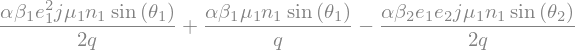

In [18]:
#edot = Gamdot/(Lam*e) - term_multiply(Lamdot, Rational(1,2)/Lam*e)
e1_dot_res = to_orbelts(Gam1_dot_res/(Lam1*e1) - term_multiply(Lam1_dot_res, Rational(1,2)/Lam1*e1)).subs(a2,a1/alpha).subs(a1,n1**Rational(-2,3))
e1_dot_res

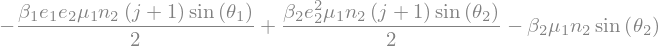

In [19]:
e2_dot_res = to_orbelts(Gam2_dot_res/(Lam2*e2) - term_multiply(Lam2_dot_res, Rational(1,2)/Lam2*e2)).subs(a2,n2**Rational(-2,3))
e2_dot_res

### $\dot\theta_0$

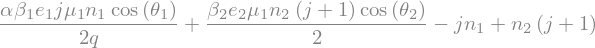

In [20]:
th0_dot_res = term_multiply(l2_dot_res, j+1) - term_multiply(l1_dot_res,j)
th0_dot_res

## Secular

### $\dot e_{1,\rm sec}$, $\dot e_{2,\rm sec}$

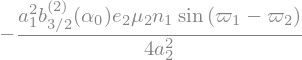

In [21]:
e1_dot_sec = -R1.diff(pom1).subs(alpha,a1/a2)/(n1*a1**2*e1)
e1_dot_sec

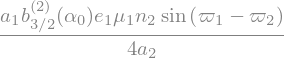

In [22]:
e2_dot_sec = -R2.diff(pom2).subs(alpha,a1/a2)/(n2*a2**2*e2)
e2_dot_sec

### $\dot \varpi_{1,\rm sec}$, $\dot \varpi_{2,\rm sec}$

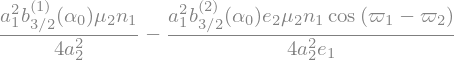

In [23]:
pom1_dot_sec = term_multiply(R1.diff(e1),1/(n1*a1**2*e1)).subs(alpha,a1/a2)
pom1_dot_sec

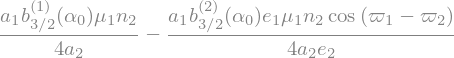

In [24]:
pom2_dot_sec = term_multiply(R2.diff(e2),1/(n2*a2**2*e2)).subs(alpha,a1/a2)
pom2_dot_sec

## Dissipative

### $\dot a_{1,\rm dis}$, $\dot a_{2,\rm dis}$

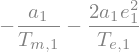

In [25]:
a1_dot_dis = term_multiply(-1/Tm1 - 2*e1**2/Te1, a1)
a1_dot_dis

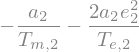

In [26]:
a2_dot_dis = term_multiply(-1/Tm2 - 2*e2**2/Te2, a2)
a2_dot_dis

### $\dot n_{1,\rm dis}$, $\dot n_{2,\rm dis}$

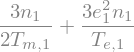

In [30]:
n1_dot_dis = term_multiply(a1_dot_dis, -Rational(3,2)*n1/a1)
n1_dot_dis

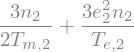

In [31]:
n2_dot_dis = term_multiply(a2_dot_dis, -Rational(3,2)*n2/a2)
n2_dot_dis

### $\dot e_{1,\rm dis}$, $\dot e_{2,\rm dis}$

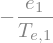

In [27]:
e1_dot_dis = -e1/Te1
e1_dot_dis

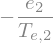

In [28]:
e2_dot_dis = -e2/Te2
e2_dot_dis

# RHS for integrations

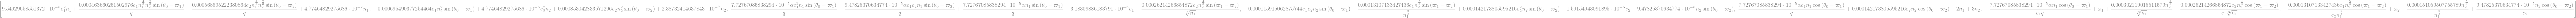

In [37]:
convs = {
    th1: th0-pom1,
    th2: th0-pom2,
    a1:n1**-Rational(2,3),
    a2:n2**-Rational(2,3)
}
params = {
    j: 2,
    mu1: 5e-5,
    mu2: 1e-4,
    b1: 1.5455341716765871,
    b2: 1.8956507412695471,
    b1_3_2: 12.08476062046314,
    b2_3_2: 10.485706741948807,
    Tm1: 0.5e6 * 2 * np.pi, # n_{2,0}^{-1}
    Tm2: 1e6 * 2 * np.pi, 
}
params[Te1] = params[Tm1] * 0.01
params[Te2] = params[Tm2] * 0.01

alpha0val = (params[j] / (params[j] + 1)) ** (2.0 / 3)

funs = [
    iterfun.subs(convs).subs(params)
    for iterfun in [
        n1_dot_res + n1_dot_dis,
        n2_dot_res + n2_dot_dis,
        e1_dot_res + e1_dot_sec + e1_dot_dis,
        e2_dot_res + e2_dot_sec + e2_dot_dis,
        th0_dot_res,
        pom1_dot_res + pom1_dot_sec,
        pom2_dot_res + pom2_dot_sec,
        ]
]
funs